## Import stuff we need

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

## Loading the data

In [11]:
import os
data_dir = "/kaggle/input/sign-language-mnist/"
train_df = pd.read_csv(data_dir + "sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv(data_dir + "sign_mnist_test/sign_mnist_test.csv")
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


## Some Vizualization and Data Exploration

In [ ]:
train_df.shape

**The data set is given in the form of labels and pixel value ranging from pixel 1 to pixel 784 which is 28 * 28 image.**

In [ ]:
labels = train['label'].values

In [ ]:
unique_val = np.array(labels)
np.unique(unique_val)

In [ ]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])

**The dataset seems balanced as for each training label , enough training examples exist**

## Cook the data (Preprocessing)

In [12]:
y_train = train_df['label'] # We need Y values - labels
# train_labels = y_train.to_numpy() # nothing smart just convert to numpy array
y_test = test_df['label']
del train_df['label'] # remove label from original dataframe to use it as X
del test_df['label']
# train_data = train_df.to_numpy()

In [13]:
# we can't use values 1,2,3,4,4,5 for Y
# instead we should use smth like [1,0,0,0,0,0], [0,1,0,0,0,0], ...
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

# https://stackoverflow.com/questions/50473381/scikit-learns-labelbinarizer-vs-onehotencoder

In [14]:
x_train = train_df.values
x_test = test_df.values

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [15]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [16]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

### Preview of first 10 images

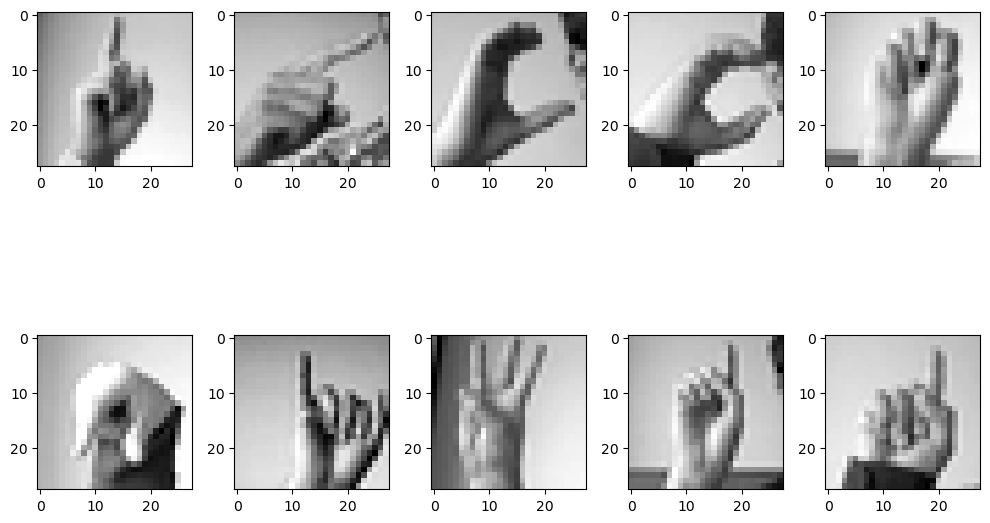

In [26]:
f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()    

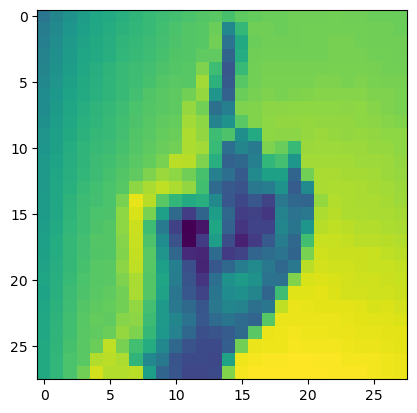

In [28]:
plt.imshow(x_train[0].reshape(28,28))

## Data Augmentation

In [17]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Building the CNN Model

In [18]:
# Compile neural network
# Define sequential model
model = Sequential()

# Define the first layer
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))

In [19]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

## Training The Model

In [30]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
# !pip install livelossplot

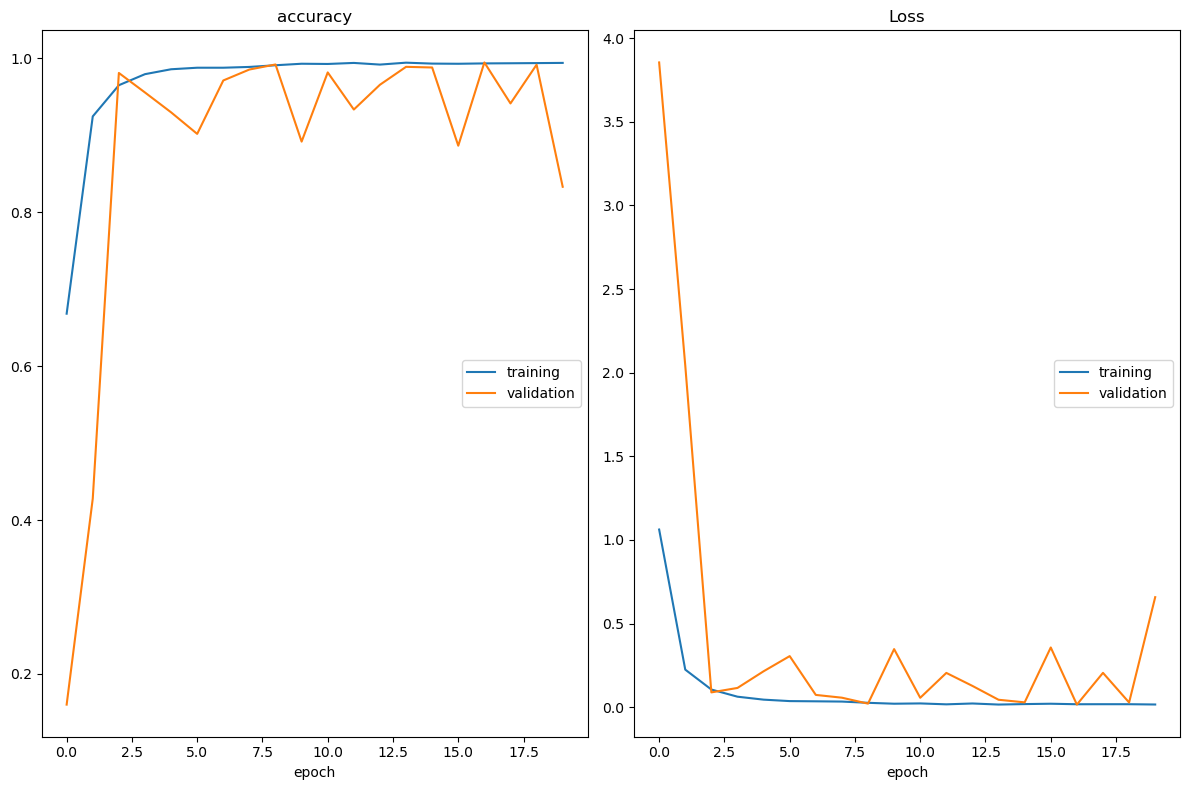

accuracy
	training         	 (min:    0.668, max:    0.995, cur:    0.994)
	validation       	 (min:    0.160, max:    0.995, cur:    0.833)
Loss
	training         	 (min:    0.016, max:    1.062, cur:    0.017)
	validation       	 (min:    0.016, max:    3.854, cur:    0.658)


In [22]:
# callbacks=[PlotLossesKeras()] - this is a single magic line of code which draw #live chart
# from livelossplot import PlotLossesKeras
# history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test), callbacks=[PlotLossesKeras()], verbose=0)

history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test), callbacks=[learning_rate_reduction])

In [24]:
# Save weight
model.save('smnist.h5')

In [ ]:
# Load weights
test_model = keras.models.load_model('smnist.h5')

## Analysis after Model Training

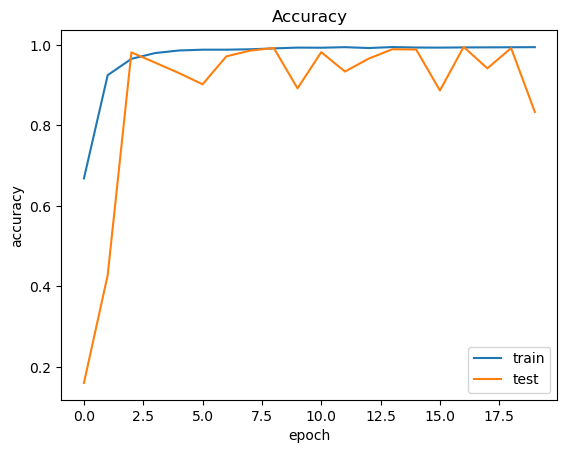

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

plt.show()

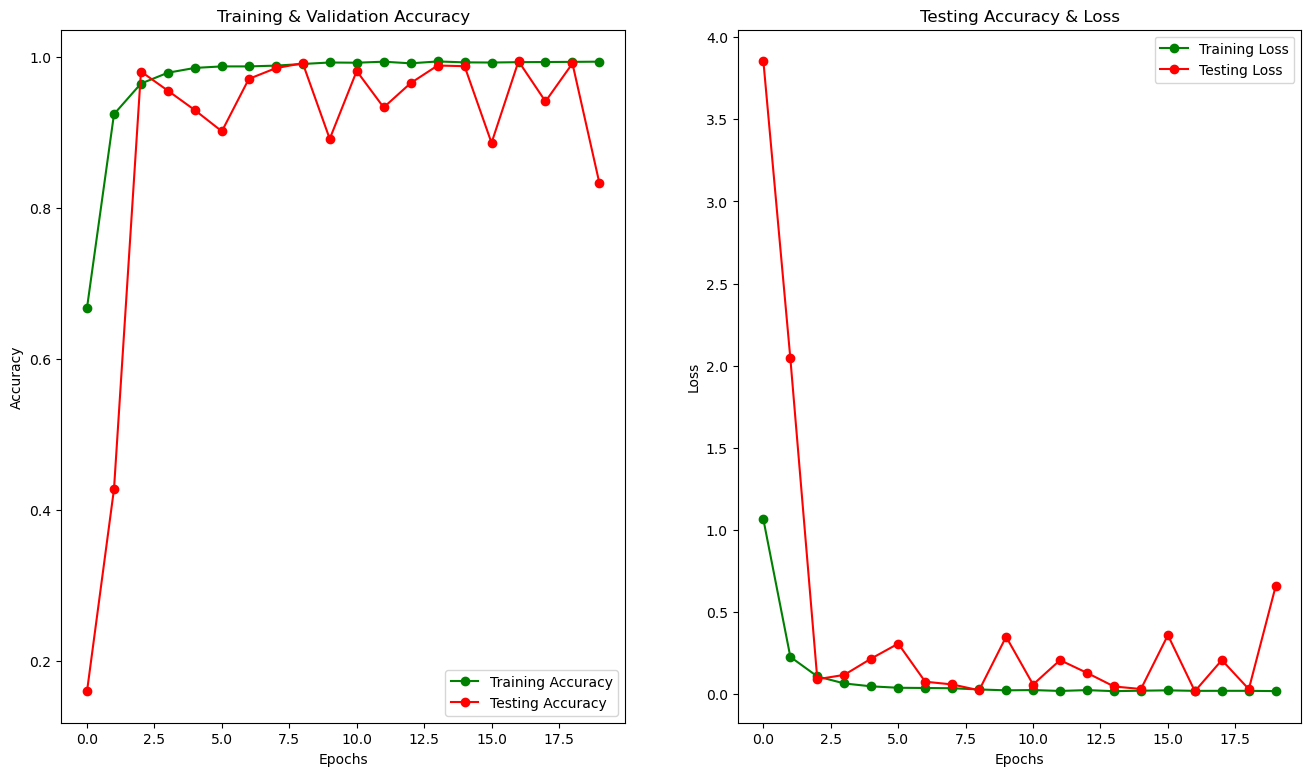

In [33]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [34]:
predictions = model.predict_classes(x_test)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]        

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [35]:
cm = confusion_matrix(y,predictions)

NameError: name 'y' is not defined

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

In [ ]:
correct = np.nonzero(predictions == y)[0]

In [ ]:
## Some of the Correctly Predicted Classes
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

In [ ]:
#  test it on test data
test_df = pd.read_csv('/content/mnist_test.csv') #might be in other place
test_labels = test_df['label'] #We need Y values - labels
test_labels = test_labels.to_numpy() # nothing smart just convert to numpy array
del test_df['label'] # remove label from original dataframe to use it as X
test_data = test_df.to_numpy()

In [23]:
# Let visualize some random item
img = test_data[3].reshape(28,28)
plt.imshow(img)

In [ ]:
# we make a trick with np array to wrap single item into array
#  because predict method predicts many values at once
y_proba = test_model.predict(np.array([test_data[3]]))
y_classes = y_proba.argmax(axis=-1)
y_classes